# Import package 

In [26]:
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm.octave import *
from qm.qua import *
from qm import generate_qua_script

#General os library 
import os
import time
import sys


import matplotlib.pyplot as plt
from qualang_tools.units import unit
from set_octave import get_L0_and_IF
from configuration_first_jump import *
from qm import SimulationConfig, LoopbackInterface
from qualang_tools.units import unit
from qualang_tools.loops import from_array
u = unit()
from qualang_tools.plot import interrupt_on_close
from qualang_tools.results import progress_counter, fetching_tool
from qualang_tools.addons.variables import assign_variables_to_element

#Path for HQCPC7 
# sys.path.append(r'C:\Users\HQClabo\Documents\Code\QuantumMachine\Guillaume\NonLinearRes_calib_30_03_2023\Analysis_Function\NonLinearRes')
# sys.path.append(r'C:\Users\HQClabo\Documents\Code\QuantumMachine\Guillaume\NonLinearRes_calib_30_03_2023\Drivers\Drivers') #path for the analysis function

#Path for HQC PC15 
sys.path.append(r'C:\Users\hqclabo\Documents\Code\gbeaulieu\Analysis_Function\NonLinearRes')
sys.path.append(r'C:\Users\hqclabo\Documents\Code\gbeaulieu\Drivers')
import AnFunc as an # analysis function
#import AnFunc as an 
import scipy.io
from scipy import signal 
from scipy.optimize import curve_fit




In [27]:
#Function for a single frequency 

def First_jump_single_freq(Readout_Len, amp_factor, IF_pump, IF_resonator, Offset_IF,Pump_Delay, n_repetition, n_empty,n_full,n_return, cooldown_time,qm): 
    
    """ Take as input :
        
        Readout_Len : length of the readout that should be the same as defined in the configuration file. Here, it is necessary for the conversion to volt
        amp_factor : multiplication factor to the pump pulse amplitude
        IF_pump : IF frequency of the pump -> necessary to update the config frequency 
        IF_resonator : If_frequency of the resonator -> necessary to update the config frequency 
        Offset_IF : general ofset if the IF of the resonator is not center 
        Pump_Delay ; time during which the pump is off but we collect datapoints 
        n_repetition : number of times the program is repeated to get an average 
        n_empty : number of measurements when the pulse is off
        n_full : number of measurements when the pulse is on
        cooldown_time : waiting time between repetitions in nb of cycles 
        qm : quantum machine 
        """ 

    with program() as IQ_blobs:

        n = declare(int)
        n_rep = declare(int)
        i = declare(int)
        I = declare(fixed)
        Q = declare(fixed)
        I_st = declare_stream()
        Q_st = declare_stream()
        f = declare(int)
        n_rep_st=declare_stream()
        
        assign_variables_to_element("resonator", I,Q) 
    
        #Update the demodulation frequency 
        update_frequency("resonator",IF_resonator+Offset_IF) 
        update_frequency("fluxline",IF_pump)

        #Loop on the repetition 
        with for_(n_rep, 0, n_rep < n_repetition, n_rep + 1):

            #Delay time before turning the pump on 
            wait(Pump_Delay,"fluxline")
            
            #Loop for playing the pump long enough 
            with for_(i, 0, i < np.round((n_full*(Readout_Len+300))/twoPhoton_len)+1, i + 1):
                play("pumping" * amp(amp_factor), 'fluxline')  


            #Demodulation measurements 
            with for_(n, 0, n < n_runs, n + 1):

                #Demodulate n time 
                measure(
                    "fake_readout",
                    "resonator",
                    None,
                    dual_demod.full("cos", "out1", "sin", "out2", I),
                    dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
                )

                save(I, I_st)
                save(Q, Q_st)

            save(n_rep, n_rep_st)

            wait(cooldown_time) #wait the cooldown 

        with stream_processing():
            I_st.with_timestamps().save_all("I")
            Q_st.with_timestamps().save_all("Q")
            n_rep_st.save("n_rep")



    simulation = False    

    if simulation:
        simulation_config = SimulationConfig(
            duration=50000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
        )

        job = qmm.simulate(config, IQ_blobs, simulation_config)
        job.get_simulated_samples().con1.plot(analog_ports={'1','2','3','4' },digital_ports={'1','3'})

    else:

        job = qm.execute(IQ_blobs)
        results = fetching_tool(job, data_list=["I", "Q","n_rep"], mode="live")

        fig = plt.figure()
        interrupt_on_close(fig, job)  #  Interrupts the job when closing the figure

        
        while results.is_processing():
            
            I, Q, n_rep = results.fetch_all()

            time=I["timestamp"]
            I = u.demod2volts(I["value"], Readout_Len) #diviser par la duree du pulse Readout_lEN 
            Q = u.demod2volts(Q["value"], Readout_Len)
            
            
            #Plotting the average 
            if len(I)>n_runs:
                
                #Datas are capted continously and then transfer into a 2D matrix and averaged
                it=len(I)//n_runs
                I_2d=I[0:it*n_runs].reshape((it,n_runs))
                Q_2d=Q[0:it*n_runs].reshape((it,n_runs))
                norm_2d=np.sqrt(I_2d**2+Q_2d**2)
                
                plt.subplot(211)
                fig.suptitle("IF_pump "+str(IF_pump)+" ite :"+str(n_rep))
                plt.cla()
                plt.plot(np.angle(I_2d[it-1,:]+1j*Q_2d[it-1,:]), ".", markersize=2)
                plt.plot([n_empty,n_empty], [-np.pi, np.pi],'r')
                plt.xlabel("Nb points")
                plt.ylabel("phase")
                plt.pause(0.1)
                
                
                plt.subplot(212)
                av=np.mean(norm_2d,axis=0) 
                plt.subplot(313)
                plt.cla()
                plt.plot(time[0:n_runs]*1e-9,av*1e3,".",markersize=2)
                plt.xlabel("time [s]")
                plt.ylabel("$\sqrt{I^2 + Q^2}$ (average) [mV]")
               
    # Returns average signal and time in ns 
    return av,time[0:n_runs],I_2d[0:n_return,:], Q_2d[0:n_return, :] 
      




def update_readout_lenght(Readout_Len,config,qmm):
    """ Macro to update the readout length in the configuration file"""
    
    #config["pulses"]["twoPhoton"]["length"]=5000 #Length of the pumping pulse
    config["pulses"]["zero_pulse"]["length"]=Readout_Len
    config["integration_weights"]["cosine_weights"]["cosine"][0]=(1.0, Readout_Len)
    config["integration_weights"]["cosine_weights"]["sine"][0]=(0.0, Readout_Len)
    config["integration_weights"]["sine_weights"]["cosine"][0]=(0.0, Readout_Len)
    config["integration_weights"]["sine_weights"]["sine"][0]=(1.0, Readout_Len)
    config["integration_weights"]["minus_sine_weights"]["cosine"][0]=(0.0, Readout_Len)
    config["integration_weights"]["minus_sine_weights"]["sine"][0]=(-1.0, Readout_Len)


    #Update the config with the modified values above 
    qm = qmm.open_qm(config)
    
    return config, qm



def update_pulse_amplitude(pulse_amp,config,qmm):
    config["waveforms"]["twoPhoton_wf"]['sample']=pulse_amp
    
    #Update the config with the modified values above 
    qm = qmm.open_qm(config)
    
    return config, qm

def update_two_photon_lenght(twoPhoton_len,config,qmm):
    """ Update the length of the fluxline pulse in the configuration file"""
    config["pulses"]["twoPhoton"]["length"]=twoPhoton_len


    #Update the config with the modified values above 
    qm = qmm.open_qm(config)
    
    return config, qm

def update_time_of_flight(time_of_flight,config,qmm):
    """ Update the time_of_flight of the qm in the configuration file """
    config["elements"]["resonator"]["time_of_flight"]=time_of_flight
    
    qm=qmm.open_qm(config)
    
    return config, qm

# OPX configuration

In [29]:
#Octave & OPX configuration 


Saving_Path=r"\\sb1files\HQC\Users\beaulieu\Data\Run01\104\\"
Cooldown_Date="2023_04_14"


opx_ip = '128.178.175.167'
opx_port = 81
octave_ip = '128.178.175.167'
octave_port = 53


octave_config = QmOctaveConfig()
octave_config.set_calibration_db(os.getcwd()) #Path to the calibration database 

octave_config.add_device_info('octave1', octave_ip, octave_port) #Add a device refered to as octave 1
octave_config.set_opx_octave_mapping([('con1', 'octave1')])  # set default mapping between analog outputs of OPX and the octave


qmm = QuantumMachinesManager(host=opx_ip, port=opx_port, octave=octave_config)
qm = qmm.open_qm(config)

octave_output_gain=-10

#Mixers for the fluxline 
qmm.octave_manager.set_clock("octave1", ClockType.External, ClockFrequency.MHZ_10) # External clock on the octave 
qm.octave.set_lo_source("fluxline", OctaveLOSource.Internal) # Use internal LO for the fluxline 
qm.octave.set_lo_frequency("fluxline", LO_fluxline)  # Set the frequency of the LO 
qm.octave.set_rf_output_gain("fluxline", octave_output_gain)  # can set gain from -10dB to 20dB
qm.octave.set_rf_output_mode("fluxline", RFOutputMode.on)  # The LO output is always on (could change to a trigger)  #RFOutputMode.trig_normal

#Mixers for the resonator 
qm.octave.set_qua_element_octave_rf_in_port("resonator", "octave1", 1) #input port 1 is set for the resonator 
qm.octave.set_downconversion("resonator", lo_source=RFInputLOSource.Internal)  # The LO for the demodulation is the interal LO  
qm.octave.set_lo_frequency("resonator", LO_readout)  # assign the LO inside the octave to element

2023-04-30 11:37:54,666 - qm - INFO - Performing health check
2023-04-30 11:37:54,678 - qm - WARNING -   HC Warning: Potential hardware issue with QSync in controller con1, multiple controllers sync cannot be guaranteed, please inform QM
2023-04-30 11:37:54,678 - qm - INFO - Health check passed


In [30]:
#Setting the gain
gain=-6
config['controllers']['con1']['analog_inputs'][1]["gain_db"]=gain
config['controllers']['con1']['analog_inputs'][2]["gain_db"]=gain
qm = qmm.open_qm(config)

time_of_flight=24
config, qm=update_time_of_flight(time_of_flight,config,qmm)

pulse_amp=0.125
config,qm=update_pulse_amplitude(pulse_amp,config,qmm)

# Display Parameter 

In [31]:
print("LO of resonator : {} GHz".format(config['elements']['resonator']["mixInputs"]["lo_frequency"]/1e9))
print("IF of resonator : {} GHz".format(config['elements']['resonator']['intermediate_frequency']/1e9))
print("Time of flight of resonator : {} ns".format(config['elements']['resonator']['time_of_flight']))
print("Readout time resonator : {} ns".format(config["pulses"]["zero_pulse"]["length"]))
print("LO of fluxline: {} GHz".format(config['elements']['fluxline']["mixInputs"]["lo_frequency"]/1e9))
print("IF of fluxline : {} GHz".format(config['elements']['fluxline']['intermediate_frequency']/1e9))
print("Fluxline pulse time : {} ns".format(config["pulses"]["twoPhoton"]["length"]))
print("Fluxline amplitude : {} V".format(config["waveforms"]["twoPhoton_wf"]['sample']))

LO of resonator : 4.2 GHz
IF of resonator : 0.318 GHz
Time of flight of resonator : 24 ns
Readout time resonator : 50000 ns
LO of fluxline: 8.5 GHz
IF of fluxline : 0.1959 GHz
Fluxline pulse time : 1000 ns
Fluxline amplitude : 0.25 V


# Testing the pump
Calibrates the pump and plays an infine tone to look at the spectrum analyzer

In [8]:
#Mixer Calibration 
#Calibration of the fluxline mixer 
qm.octave.calibrate_element("fluxline", [get_L0_and_IF(config, "fluxline")])  
qm = qmm.open_qm(config)

2023-04-24 11:44:05,424 - qm - INFO - Flags: 
2023-04-24 11:44:05,425 - qm - INFO - Compiling program
2023-04-24 11:44:08,173 - qm - INFO - Sending pre-compiled program to QOP


In [15]:
# Testing the pump 

with program() as TwoPhoton:
    with infinite_loop_():
        play("pumping"*amp(0.1), 'fluxline')
        
job = qm.execute(TwoPhoton)

2023-02-16 16:39:23,541 - qm - INFO - Flags: 
2023-02-16 16:39:23,541 - qm - INFO - Sending program to QOP
2023-02-16 16:39:23,568 - qm - INFO - Executing program


In [15]:
#Two stop the two photon pumping 
job.halt()

True

# Single measurement multiple times with dual demodualtion

For this measurement, you want to keep a photon length pulse quite smaller than the readout length

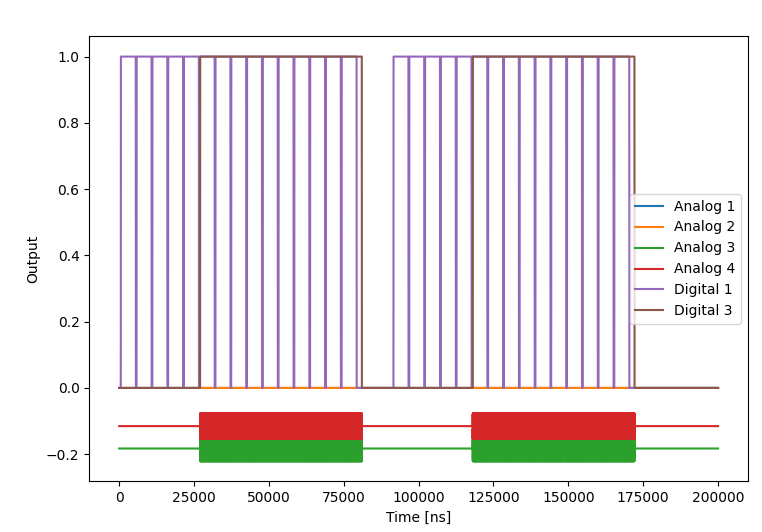!

In [64]:
%%time
%matplotlib qt
freqs_dict={}
Readout_Len=50_000
config,qm=update_readout_lenght(Readout_Len,config,qmm)

amp_factor_array=np.array([0.5]) #Prefactor of the amplitude 
amp_factor=amp_factor_array[0]

#Update the pump IF frequency 

freqs_dict[amp_factor]=np.array([ 196e6]) # 

IF_pump=freqs_dict[amp_factor][0]
IF_resonator=(LO_fluxline+IF_pump)/2-LO_readout #demodulate at half of the pump IF by default 

n_repetition=30 #number of repetitions 

n_empty=1000 #number of vaccum readout to do 
Pump_Delay = n_empty*(Readout_Len+300)//4  #time for the pump to be off 
n_full=30_000 #number of pump on readout to do 
n_runs=n_empty+n_full # Total number of readout to do 
n_return=10

cooldown_time=16//4 #5_000_000//4 #cooldown time before each repetition to go back to vacuum 
Offset_IF=0  

Expected_time=(Readout_Len*n_runs*1e-9*n_repetition+n_repetition*(cooldown_time*4*1e-9+Pump_Delay*4*1e-9))/60


av,time, I, Q=First_jump_single_freq(Readout_Len, amp_factor, IF_pump, IF_resonator, Offset_IF,Pump_Delay, n_repetition, n_empty,n_full, n_return, cooldown_time,qm)

Data={}
Data[amp_factor]={}
Data[amp_factor][IF_pump]={}
Data[amp_factor][IF_pump]["value"]=av
Data[amp_factor][IF_pump]["time"]=time
Data[amp_factor][IF_pump]["I"]=I
Data[amp_factor][IF_pump]["Q"]=Q

2023-04-30 12:32:04,927 - qm - INFO - Flags: 
2023-04-30 12:32:04,927 - qm - INFO - Sending program to QOP
2023-04-30 12:32:05,384 - qm - INFO - Executing program
Execution stopped by user!
Wall time: 13.5 s


## Plotting for single frequency 

In [39]:
#Plot and fit Data 

number_avg=10
Processed_Data=an.Extract_vac_exc_gap(Data,amp_factor_array,freqs_dict,n_empty,number_avg)

amp_factor=amp_factor_array[0]
freqs=freqs_dict[amp_factor]

for idx in range(len(freqs)):
    
    if Processed_Data[amp_factor][freqs[idx]]["fit"]:

        gap=Processed_Data[amp_factor][freqs[idx]]["gap"]
        coeff=Processed_Data[amp_factor][freqs[idx]]["fit_coeff"]
        time_fit=Processed_Data[amp_factor][freqs[idx]]["time_fit"]
        y_fitted=Processed_Data[amp_factor][freqs[idx]]["y_fitted"]
        av_fit=Processed_Data[amp_factor][freqs[idx]]["av_fit"]

        fontsize=8
        fig, axs = plt.subplots( nrows=2, ncols=1, figsize=(8,10),dpi=100)

        #Plotting the measurement 
        ax=axs[0]
        ax.set_title("Average "+str(n_repetition))
        ax.plot(time*1e-9,av*1e3)
        ax.plot([Pump_Delay*4*1e-9,Pump_Delay*4*1e-9],[0, max(av*1e3)],"r")
        ax.set_xlabel("time [s]")
        ax.set_ylabel("$\sqrt{I^2 + Q^2}$ (average) [mV]")

        ax=axs[1]
        ax.set_title("$\lambda= $"+str(gap))
        ax.plot(time_fit,av_fit)
        ax.plot(time_fit,y_fitted)
        ax.set_xlabel("time [s]")
        ax.set_ylabel("$\sqrt{I^2 + Q^2}$ (average) [mV]")



    else:
        print("No fit")
        time_fit=Processed_Data[amp_factor][freqs[idx]]["time_fit"]
        av_fit=Processed_Data[amp_factor][freqs[idx]]["av_fit"]
        
        fontsize=8
        fig, axs = plt.subplots( nrows=2, ncols=1, figsize=(8,10),dpi=100)

        #Plotting the measurement 
        ax=axs[0]
        ax.set_title("Average "+str(n_repetition))
        ax.plot(time*1e-9,av*1e3)
        ax.plot([Pump_Delay*4*1e-9,Pump_Delay*4*1e-9],[0, max(av*1e3)],"r")
        ax.set_xlabel("time [s]")
        ax.set_ylabel("$\sqrt{I^2 + Q^2}$ (average) [mV]")

        ax=axs[1]
        ax.set_title("Pump= "+str(freqs[idx]) +" Iteration :" +str(idx) + " No fit")
        ax.plot(time_fit,av_fit)
        ax.set_xlabel("time [s]")
        ax.set_ylabel("$\sqrt{I^2 + Q^2}$ (average) [mV]")
        

## Saving for a single frequency

In [259]:
#Saving the data
cooldown_date=Cooldown_Date #top folder 
device="vac_to_excit" #second folder 
name="Single_freq" # third folder 
meastype="filename" #Final file name 

datadict={}
#Configuration file copy 
datadict["LO_fluxline"]=LO_fluxline
datadict["IF_fluxline"]=IF_pump
datadict["IF_readout"]=IF_resonator
datadict["LO_readout"]=LO_readout

datadict["octave_output_gain"]=octave_output_gain

#Saving of parameters 
datadict["n_empty"]=n_empty
datadict["n_repetition"]=n_repetition
datadict["n_full"]=n_full
datadict["amp_factor_array"]=amp_factor_array
datadict["Offset_IF"]=Offset_IF
datadict["Readout_Len"]=Readout_Len
datadict["Pump_Delay"]=Pump_Delay
datadict["cooldown_time"]=cooldown_time

#Saving of data 
datadict["freqs_dict"]=freqs_dict
datadict["Data"]=Data
datadict["config"]=config


In [260]:
an.save_with_numpy(datadict, meastype, name, device, cooldown_date, filepath=Saving_Path)

saving in new directory


In [240]:
#loading the data 
filepath=r"\\sb1files\HQC\Users\beaulieu\Data\Run01\104\2023_04_14\vac_to_excit\Single_trace\filename.npz"

npzfile=np.load(filepath,allow_pickle=True)
npzfile["multidata"][()]
freqs_dict=npzfile["multidata"][()]["freqs_dict"]
Data=npzfile["multidata"][()]["Data"]
amp_factor_array=npzfile["multidata"][()]["amp_factor_array"]
n_empty=npzfile["multidata"][()]["n_empty"]

# Multiple frequencies of single measurement with dual demodualtion 


In [57]:
#Select the frequencies 
freqs_dict={}

amp_factor_array=np.array([0.6]) #Prefactor of the amplitude 
amp_factor=amp_factor_array[0]

fmin=195.8e6
fmax=196e6
df=0.05* u.MHz
freqs=np.arange(fmin, fmax+df/2, df)



# span=1.3 * u.MHz # Span of the pumping 
# df = 0.1* u.MHz # Step of the pumping 0.01
# IF_center=0.1954e9 
# freqs = np.arange(IF_center-span/2, IF_center+span/2, df) #sets of frequencies


#add all the frequencies 
freqs_dict[amp_factor]=freqs

freqs

array([1.9580e+08, 1.9585e+08, 1.9590e+08, 1.9595e+08, 1.9600e+08])

In [58]:
%matplotlib qt 

Readout_Len=50_000
config,qm=update_readout_lenght(Readout_Len,config,qmm)

n_repetition=30 #number of repetitions 

n_empty=10_000 #number of vaccum readout to do 
Pump_Delay = n_empty*(Readout_Len+300)//4  #time for the pump to be off 
n_full=30_000 #number of pump on readout to do 
n_runs=n_empty+n_full # Total number of readout to do 
n_return=10

cooldown_time=16//4 #cooldown time before each repetition to go back to vacuum 
Offset_IF=0  

#Saving the data
save_Data=False
cooldown_date=Cooldown_Date #top folder 
device="vac_to_excit" #second folder 
name="Multiple_freq" # third folder 
meastype="0p275_test" #Final file name 


print("The different frequency {}".format(freqs))
Expected_time=(Readout_Len*n_runs*1e-9*n_repetition+n_repetition*(cooldown_time*4*1e-9+Pump_Delay*4*1e-9))/60*len(freqs)
print("The expected time : {} min".format(Expected_time))

The different frequency [1.9580e+08 1.9585e+08 1.9590e+08 1.9595e+08 1.9600e+08]
The expected time : 6.25750004 min


In [59]:
%%time


Data={} #dictionnary to hold all the data 
Data[amp_factor]={}
for idx,IF_pump in enumerate(freqs) :
    
    print("########################### Frequency "+str(IF_pump+LO_fluxline)+"########################### "+str(idx/len(freqs)))

    IF_resonator=(LO_fluxline+IF_pump)/2-LO_readout #demodulate at half of the pump IF by default 
    
    av,time, I, Q=First_jump_single_freq(Readout_Len, amp_factor, IF_pump, IF_resonator, Offset_IF,Pump_Delay, n_repetition, n_empty,n_full, n_return, cooldown_time,qm)
    plt.close()
    
    Data[amp_factor][IF_pump]={}
    Data[amp_factor][IF_pump]["value"]=av
    Data[amp_factor][IF_pump]["time"]=time
    Data[amp_factor][IF_pump]["I"]=I 
    Data[amp_factor][IF_pump]["Q"]=Q
    
    
if save_Data:
    
    datadict={}
    datadict["LO_fluxline"]=LO_fluxline
    datadict["IF_fluxline"]=IF_pump
    datadict["IF_readout"]=IF_resonator
    datadict["LO_readout"]=LO_readout

    datadict["octave_output_gain"]=octave_output_gain
    datadict["n_empty"]=n_empty
    datadict["n_repetition"]=n_repetition
    datadict["n_full"]=n_full
    datadict["amp_factor_array"]=amp_factor_array
    datadict["Offset_IF"]=Offset_IF
    datadict["Readout_Len"]=Readout_Len
    datadict["Pump_Delay"]=Pump_Delay
    datadict["cooldown_time"]=cooldown_time
    datadict["Data"]=Data
    datadict["freqs_dict"]=freqs_dict
    datadict["config"]=config
    
    an.save_with_numpy(datadict, meastype, name, device, cooldown_date, filepath=Saving_Path)
    
    

########################### Frequency 8695800000.0########################### 0.0
2023-04-30 12:21:12,187 - qm - INFO - Flags: 
2023-04-30 12:21:12,187 - qm - INFO - Sending program to QOP
2023-04-30 12:21:12,649 - qm - INFO - Executing program
Execution stopped by user!
########################### Frequency 8695850000.0########################### 0.2
2023-04-30 12:22:14,766 - qm - INFO - Flags: 
2023-04-30 12:22:14,766 - qm - INFO - Sending program to QOP
2023-04-30 12:22:15,231 - qm - INFO - Executing program
Execution stopped by user!
########################### Frequency 8695900000.0########################### 0.4
2023-04-30 12:23:17,203 - qm - INFO - Flags: 
2023-04-30 12:23:17,203 - qm - INFO - Sending program to QOP
2023-04-30 12:23:18,111 - qm - INFO - Executing program
Execution stopped by user!
########################### Frequency 8695950000.0########################### 0.6
2023-04-30 12:24:19,652 - qm - INFO - Flags: 
2023-04-30 12:24:19,653 - qm - INFO - Sending program to

## Saving for multiple frequencies 

In [19]:
#Saving the data 
cooldown_date=Cooldown_Date #top folder 
device="vac_to_excit" #second folder 
name="Multiple_freq" # third folder 
meastype="Test_crap" #Final file name 

datadict={}
datadict["LO_fluxline"]=LO_fluxline
datadict["IF_fluxline"]=IF_pump
datadict["IF_readout"]=IF_resonator
datadict["LO_readout"]=LO_readout
datadict["octave_output_gain"]=octave_output_gain

datadict["n_empty"]=n_empty
datadict["n_repetition"]=n_repetition
datadict["n_full"]=n_full
datadict["amp_factor_array"]=amp_factor_array
datadict["Offset_IF"]=Offset_IF
datadict["Readout_Len"]=Readout_Len
datadict["Pump_Delay"]=Pump_Delay
datadict["cooldown_time"]=cooldown_time
datadict["Data"]=Data
datadict["config"]=config
datadict["freqs_dict"]=freqs_dict 

an.save_with_numpy(datadict, meastype, name, device, cooldown_date, filepath=Saving_Path)

saving


In [8]:
#Loading the data 

filepath= r"\\sb1files\HQC\Users\beaulieu\Data\Run01\104\2023_04_14\vac_to_excit\Multiple_freq\Test_crap.npz"

npzfile=np.load(filepath,allow_pickle=True)
#npzfile["multidata"][()]

Data=npzfile["multidata"][()]["Data"]
freqs_dict=npzfile["multidata"][()]["freqs_dict"]
amp_factor_array=npzfile["multidata"][()]["amp_factor_array"]
n_empty=npzfile["multidata"][()]["n_empty"]

## Plotting for a multiple frequencies

In [60]:
%matplotlib qt
#Plot all 
number_avg=10
Processed_Data=an.Extract_vac_exc_gap(Data,amp_factor_array,freqs_dict,n_empty,number_avg)
amp_factor=amp_factor_array[0]
freqs=freqs_dict[amp_factor]

for idx in range(len(freqs)):
    
    if Processed_Data[amp_factor][freqs[idx]]["fit"]:

        gap=Processed_Data[amp_factor][freqs[idx]]["gap"]
        coeff=Processed_Data[amp_factor][freqs[idx]]["fit_coeff"]
        time_fit=Processed_Data[amp_factor][freqs[idx]]["time_fit"]
        y_fitted=Processed_Data[amp_factor][freqs[idx]]["y_fitted"]
        av_fit=Processed_Data[amp_factor][freqs[idx]]["av_fit"]

        fontsize=8
        fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5,5),dpi=100)
        ax=axs
        ax.set_title("Pump= "+str(freqs[idx]) +" Iteration :" +str(idx)+" $\lambda= $"+str(round(gap,2)))
        ax.plot(time_fit,av_fit)
        ax.plot(time_fit,y_fitted)
        ax.set_xlabel("time [s]")
        ax.set_ylabel("$\sqrt{I^2 + Q^2}$ (average) [mV]")



    else:
        print("No fit")
        time_fit=Processed_Data[amp_factor][freqs[idx]]["time_fit"]
        av_fit=Processed_Data[amp_factor][freqs[idx]]["av_fit"]
        fontsize=8
        fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5,5),dpi=100)
        ax=axs
        ax.set_title("Pump= "+str(freqs[idx]) +" Iteration :" +str(idx) + " No fit")
        ax.plot(time_fit,av_fit)
        ax.set_xlabel("time [s]")
        ax.set_ylabel("$\sqrt{I^2 + Q^2}$ (average) [mV]")

No fit


In [9]:
plt.close("all")

## Extracting the Liouivillian gap 

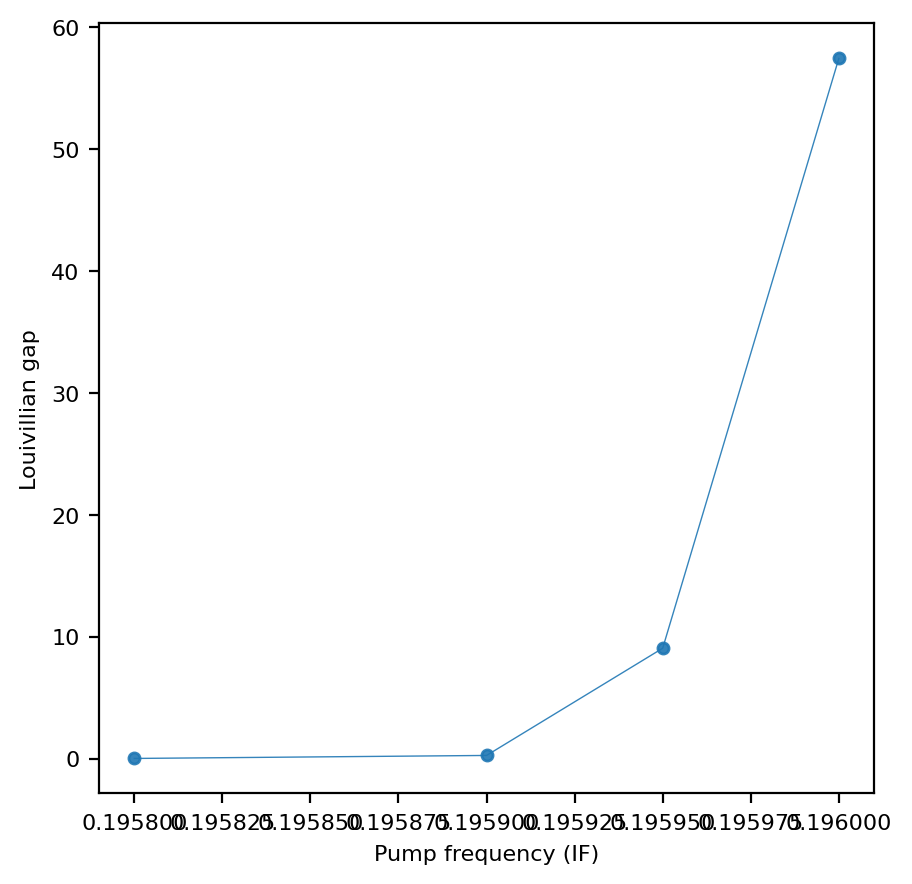

In [61]:
%matplotlib inline


amp_factor=amp_factor_array[0]
freqs=freqs_dict[amp_factor]

gap_array=[]
freq_gap_array=[]

for idx in range(len(freqs)):
    
    if Processed_Data[amp_factor][freqs[idx]]["fit"]:
        gap_array.append(Processed_Data[amp_factor][freqs[idx]]["gap"])
        freq_gap_array.append(freqs[idx])
        
gap_array=np.array(gap_array)
freq_gap_array=np.array(freq_gap_array)
        
        

# figsize=(5,4)

fontsize=8
figsize=(5,4)
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5,5),dpi=200)

axs.plot(freq_gap_array/1e9,gap_array,'.-',alpha=.9, lw=.5, ms=8)
axs.set_xlabel("Pump frequency (IF)",fontsize=fontsize)
axs.set_ylabel("Louivillian gap",fontsize=fontsize)
axs.tick_params(axis='x', labelsize=fontsize)
axs.tick_params(axis='y', labelsize=fontsize)
        

#  Multiple amplitudes with multiple frequencies 

Runs the previous measurement but for multiple amplitudes 

In [68]:
#Select the frequencies & amplitudes factors 

#Sets of amplitude factors 
amp_factor_array=np.array([0.5, 0.6]) 

fmin=195.9e6
fmax=196.15e6
df=0.05* u.MHz
freqs_array_1=np.arange(fmin, fmax+df/2, df)

fmin=195.8e6
fmax=196e6
df=0.05* u.MHz
freqs_array_2=np.arange(fmin, fmax+df/2, df)

freqs_dict={}
freqs_dict[0.5]=freqs_array_1
freqs_dict[0.6]=freqs_array_2

#calculate the total number of frequencies 
number_frequencies=0
for i in range(len(amp_factor_array)):
    number_frequencies+=len(freqs_dict[amp_factor_array[i]])

    
#IF centers 
# IF_center=[0.1957e9, 0.19565e9]

# span=0.1 * u.MHz # Span of the pumping 
# df = 0.02* u.MHz # Step of the pumping 0.01

# freqs_array=np.zeros((len(amp_factor_array),round(span/df)))

# for i in range(len(amp_factor_array)):
#     freqs_array[i,:]=np.arange(IF_center[i]-span/2, IF_center[i]+span/2, df) #sets of frequencies



freqs_dict

{0.5: array([1.9590e+08, 1.9595e+08, 1.9600e+08, 1.9605e+08, 1.9610e+08,
        1.9615e+08]),
 0.6: array([1.9580e+08, 1.9585e+08, 1.9590e+08, 1.9595e+08, 1.9600e+08])}

In [71]:
%matplotlib qt 

Readout_Len=50_000
config,qm=update_readout_lenght(Readout_Len,config,qmm)

n_repetition=30 #number of repetitions 

n_empty=100 #number of vaccum readout to do 
Pump_Delay = n_empty*(Readout_Len+300)//4  #time for the pump to be off 
n_full=30_000 #number of pump on readout to do 
n_runs=n_empty+n_full # Total number of readout to do 
n_return=1

cooldown_time=16//4 #cooldown time before each repetition to go back to vacuum 
Offset_IF=0  


save_Data=False
#Saving the data
cooldown_date=Cooldown_Date #top folder 
device="vac_to_excit" #second folder 
name="Multiple_amplitude" # third folder 
meastype="filename_1" #Final file name 



Expected_time=(Readout_Len*n_runs*1e-9*n_repetition+n_repetition*(cooldown_time*4*1e-9+Pump_Delay*4*1e-9))/60*(number_frequencies)
print("The expected time : {} min".format(Expected_time))

The expected time : 8.305165088 min


In [72]:
%%time 

Data={} #dictionnary to hold all the data 

for i in range(len(amp_factor_array)):

    amp_factor=amp_factor_array[i]
    freqs=freqs_dict[amp_factor] 
    
    print("####################################### Amplitude "+str(amp_factor)+"######################################## ")
   
    Data[amp_factor]={}
          
    for idx,IF_pump in enumerate(freqs):

        print("########################### Frequency "+str(IF_pump+LO_fluxline)+"########################### "+str(idx/len(freqs)))

        IF_resonator=(LO_fluxline+IF_pump)/2-LO_readout #demodulate at half of the pump IF by default 

        av,time, I, Q=First_jump_single_freq(Readout_Len, amp_factor, IF_pump, IF_resonator, Offset_IF,Pump_Delay, n_repetition, n_empty,n_full, n_return, cooldown_time,qm)
        plt.close()
        
        Data[amp_factor][IF_pump]={}
        Data[amp_factor][IF_pump]["value"]=av
        Data[amp_factor][IF_pump]["time"]=time
        Data[amp_factor][IF_pump]["I"]=I
        Data[amp_factor][IF_pump]["Q"]=Q
    
    
if save_Data:
    
    datadict={}
    datadict["LO_fluxline"]=LO_fluxline
    datadict["IF_fluxline"]=IF_pump
    datadict["IF_readout"]=IF_resonator
    datadict["LO_readout"]=LO_readout

    
    datadict["octave_output_gain"]=octave_output_gain
    datadict["n_empty"]=n_empty
    datadict["n_repetition"]=n_repetition
    datadict["n_full"]=n_full
    datadict["amp_factor_array"]=amp_factor_array
    datadict["Offset_IF"]=Offset_IF
    datadict["Readout_Len"]=Readout_Len
    datadict["Pump_Delay"]=Pump_Delay
    datadict["cooldown_time"]=cooldown_time
    datadict["Data"]=Data
    datadict["freqs_dict"]=freqs_dict
    datadict["config"]=config
    
    an.save_with_numpy(datadict, meastype, name, device, cooldown_date, filepath=Saving_Path)

####################################### Amplitude 0.5######################################## 
########################### Frequency 8695900000.0########################### 0.0
2023-04-30 12:34:58,150 - qm - INFO - Flags: 
2023-04-30 12:34:58,150 - qm - INFO - Sending program to QOP
2023-04-30 12:34:58,626 - qm - INFO - Executing program
Execution stopped by user!
########################### Frequency 8695950000.0########################### 0.16666666666666666
2023-04-30 12:35:45,256 - qm - INFO - Flags: 
2023-04-30 12:35:45,256 - qm - INFO - Sending program to QOP
2023-04-30 12:35:46,087 - qm - INFO - Executing program
Execution stopped by user!
########################### Frequency 8696000000.0########################### 0.3333333333333333
2023-04-30 12:36:32,393 - qm - INFO - Flags: 
2023-04-30 12:36:32,393 - qm - INFO - Sending program to QOP
2023-04-30 12:36:33,196 - qm - INFO - Executing program
Execution stopped by user!
########################### Frequency 8696050000.0########

## Saving for multiple amplitudes 

In [22]:
#Saving the data 
cooldown_date=Cooldown_Date #top folder 
device="vac_to_excit" #second folder 
name="Multiple_amp" # third folder 
meastype="Test_2" #Final file name 

datadict={}
datadict["LO_fluxline"]=LO_fluxline
datadict["IF_fluxline"]=IF_pump
datadict["IF_readout"]=IF_resonator
datadict["LO_readout"]=LO_readout

datadict["octave_output_gain"]=octave_output_gain

datadict["n_empty"]=n_empty
datadict["n_repetition"]=n_repetition
datadict["n_full"]=n_full
datadict["amp_factor_array"]=amp_factor_array
datadict["Offset_IF"]=Offset_IF
datadict["Readout_Len"]=Readout_Len
datadict["Pump_Delay"]=Pump_Delay
datadict["cooldown_time"]=cooldown_time
datadict["Data"]=Data
datadict["freqs_dict"]=freqs_dict
datadict["config"]=config

an.save_with_numpy(datadict, meastype, name, device, cooldown_date, filepath=Saving_Path)

saving


In [7]:
#Loading the data 
filepath= r"\\sb1files\HQC\Users\beaulieu\Data\Run01\104\2023_04_14\vac_to_excit\Multiple_amp\Test_crap.npz"

npzfile=np.load(filepath,allow_pickle=True)
#npzfile["multidata"][()]

n_empty=npzfile["multidata"][()]["n_empty"]
Data=npzfile["multidata"][()]["Data"]
freqs_dict=npzfile["multidata"][()]["freqs_dict"]
amp_factor_array=npzfile["multidata"][()]["amp_factor_array"]

FileNotFoundError: [Errno 2] No such file or directory: '\\\\sb1files\\HQC\\Users\\beaulieu\\Data\\Run01\\104\\2023_04_14\\vac_to_excit\\Multiple_amp\\Test_crap.npz'

## Ploting for multiple amplitudes 

In [74]:
%matplotlib qt
#Plot all 
number_avg=10
Processed_Data=an.Extract_vac_exc_gap(Data,amp_factor_array,freqs_dict,n_empty,number_avg)
j=1
amp_factor=amp_factor_array[j]
freqs=freqs_dict[amp_factor]

for idx in range(len(freqs)):
    
    if Processed_Data[amp_factor][freqs[idx]]["fit"]:

        gap=Processed_Data[amp_factor][freqs[idx]]["gap"]
        coeff=Processed_Data[amp_factor][freqs[idx]]["fit_coeff"]
        time_fit=Processed_Data[amp_factor][freqs[idx]]["time_fit"]
        y_fitted=Processed_Data[amp_factor][freqs[idx]]["y_fitted"]
        av_fit=Processed_Data[amp_factor][freqs[idx]]["av_fit"]

        fontsize=8
        fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5,5),dpi=100)
        ax=axs
        ax.set_title("Pump= "+str(freqs[idx]) +" Iteration :" +str(idx)+" $\lambda= $"+str(round(gap,2)))
        ax.plot(time_fit,av_fit)
        ax.plot(time_fit,y_fitted)
        ax.set_xlabel("time [s]")
        ax.set_ylabel("$\sqrt{I^2 + Q^2}$ (average) [mV]")



    else:
        print("No fit")
        time_fit=Processed_Data[amp_factor][freqs[idx]]["time_fit"]
        av_fit=Processed_Data[amp_factor][freqs[idx]]["av_fit"]
        fontsize=8
        fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5,5),dpi=100)
        ax=axs
        ax.set_title("Pump= "+str(freqs[idx]) +" Iteration :" +str(idx) + " No fit")
        ax.plot(time_fit,av_fit)
        ax.set_xlabel("time [s]")
        ax.set_ylabel("$\sqrt{I^2 + Q^2}$ (average) [mV]")

No fit


## Extracting the Liouivillian gap

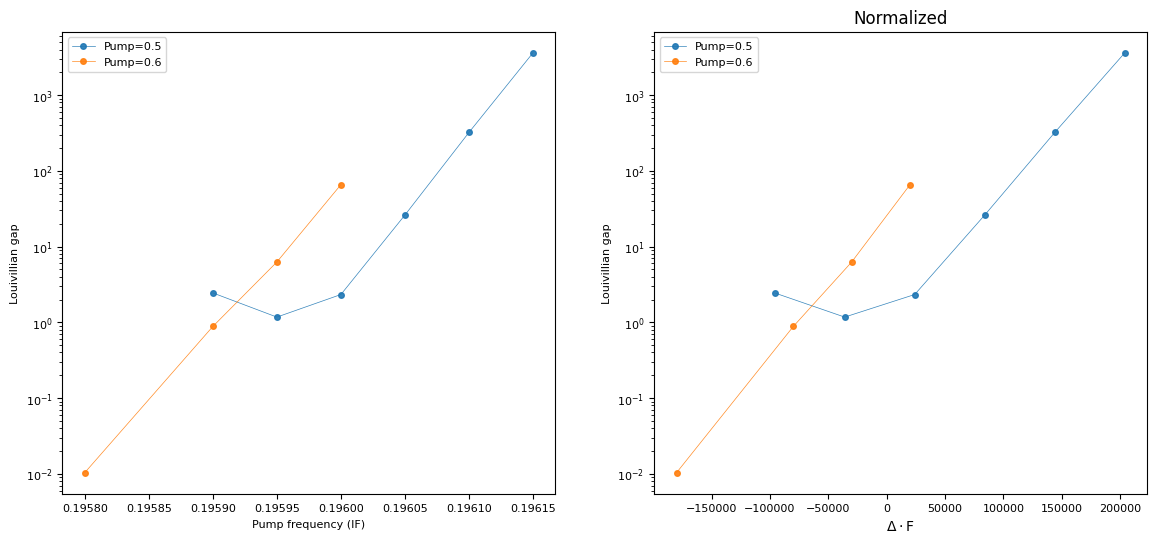

In [75]:
%matplotlib inline

center_freq=4.34799e9*2
Gi=0.6

fontsize=8
figsize=(5,4)
fig, axs = plt.subplots( ncols=2, figsize=(14,6))

for j in range(len(amp_factor_array)):
    
    amp_factor=amp_factor_array[j]
    freqs=freqs_dict[amp_factor]
    gap_array=[]
    freq_gap_array=[]
    
    for idx in range(len(freqs)):

        if Processed_Data[amp_factor][freqs[idx]]["fit"]:
            gap_array.append(Processed_Data[amp_factor][freqs[idx]]["gap"])
            freq_gap_array.append(freqs[idx])
        
    gap_array=np.array(gap_array)
    freq_gap_array=np.array(freq_gap_array)
    
    ax=axs[0]
    ax.plot(freq_gap_array/1e9,gap_array,".-",label=f'Pump={amp_factor:.1f}', alpha=.9, lw=.5, ms=8)    
    ax=axs[1]
    Gx=amp_factor
    ax.plot( ((freq_gap_array+LO_fluxline)-center_freq)*Gi/Gx,gap_array,".-",label=f'Pump={amp_factor:.1f}', alpha=.9, lw=.5, ms=8)
  
ax=axs[0]
ax.set_xlabel("Pump frequency (IF)",fontsize=fontsize)
ax.set_ylabel("Louivillian gap",fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)  
ax.legend(fontsize=fontsize)
ax.set_yscale('log')

ax=axs[1]
ax.set_title("Normalized")
ax.set_ylabel("Louivillian gap",fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize) 
ax.set_xlabel('$\Delta\cdot$F')
ax.legend(fontsize=fontsize)
ax.set_yscale('log')


# Other

## Sliced demod 

In [ ]:
# I and Q time trace directly from OPX out to OPX IN 
%matplotlib qt

Readout_Len=100_000
config,qm=update_readout_lenght(Readout_Len,config,qmm)


chunk_size = 10 #unit cycle 
n_chunks = Readout_Len//(4 * chunk_size) # chunk size

with program() as IQ_blobs:
    
    
    n = declare(int)
    i = declare(int)
    I_1 = declare(fixed, size=n_chunks)
    Q_1 = declare(fixed, size=n_chunks)
    I_2 = declare(fixed, size=n_chunks)
    Q_2 = declare(fixed, size=n_chunks)
    I = declare(fixed, size=n_chunks)
    Q = declare(fixed, size=n_chunks)
    I_st = declare_stream()
    Q_st = declare_stream()

    measure(
        "fake_readout",
        "resonator",
        None,
        demod.sliced("cos",I_1, chunk_size, "out1"),
        demod.sliced("sin",I_2, chunk_size, "out2"),
        demod.sliced("minus_sin",Q_1, chunk_size, "out1"),
        demod.sliced("cos",Q_2, chunk_size, "out2"),
    )
    with for_(i, 0, i<n_chunks, i+1):

        assign(I[i],I_1[i]+I_2[i])
        assign(Q[i],Q_1[i]+Q_2[i])

        save(I[i], I_st)
        save(Q[i], Q_st)

    #wait(cooldown_time, "resonator")

    with stream_processing():
        I_st.save_all("I")
        Q_st.save_all("Q")

        
        
simulation = False

if simulation:
    simulation_config = SimulationConfig(
        duration=8000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
    )
    job = qmm.simulate(config, IQ_blobs, simulation_config)
    job.get_simulated_samples().con1.plot()
    
else:
  
    # Live plotting
    fig = plt.figure()
    job = qm.execute(IQ_blobs)
    results = fetching_tool(job, data_list=["I", "Q"], mode="live")
    interrupt_on_close(fig, job) 
    
    while results.is_processing():
    
        I, Q = results.fetch_all()
        I = u.demod2volts(I,4 * chunk_size)
        Q = u.demod2volts(Q,4 * chunk_size)

        time=np.arange(n_chunks)*(4 * chunk_size)

        plt.subplot(211)
        plt.cla()
        plt.title("IQ blobs")
        plt.plot(time, I, '.')
        plt.xlabel("time")
        plt.ylabel("I")
        plt.subplot(212)
        plt.plot(time, Q,'.')
        plt.xlabel("time")
        plt.ylabel("Q")
        plt.tight_layout()
        #plt.axis("equal")


## Average Test - Failure

Problem is that I am averaging on I and Q which are not positive and negative, This was adjusted, but do not seem to work better 

In [153]:

def First_jump_single_freq_average(Readout_Len, amp_factor, IF_pump, IF_resonator, Offset_IF,Pump_Delay, n_repetition, n_empty,n_full, cooldown_time,qm): 
    
    """ Take as input :
        
        Readout_Len : length of the readout that should be the same as defined in the configuration file. Here, it is necessary for the conversion to volt
        amp_factor : multiplication factor to the pump pulse amplitude
        IF_pump : IF frequency of the pump -> necessary to update the config frequency 
        IF_resonator : If_frequency of the resonator -> necessary to update the config frequency 
        Offset_IF : general ofset if the IF of the resonator is not center 
        Pump_Delay ; time during which the pump is off but we collect datapoints 
        n_repetition : number of times the program is repeated to get an average 
        n_empty : number of measurements when the pulse is off
        n_full : number of measurements when the pulse is on
        cooldown_time : waiting time between repetitions 
        qm : quantum machine 
        """ 

    with program() as IQ_blobs:

        n = declare(int)
        n_rep = declare(int)
        i = declare(int)
        I = declare(fixed)
        Q = declare(fixed)
        I_st = declare_stream()
        Q_st = declare_stream()
        time_st=declare_stream()
        f = declare(int)
        n_rep_st=declare_stream()
        
        assign_variables_to_element("resonator", I,Q) 
    
        #Update the demodulation frequency 
        update_frequency("resonator",IF_resonator+Offset_IF) 
        update_frequency("fluxline",IF_pump)

        #Loop on the repetition 
        with for_(n_rep, 0, n_rep < n_repetition, n_rep + 1):

            #Delay time before turning the pump on 
            wait(Pump_Delay,"fluxline")
            
            #Loop for playing the pump long enough 
            with for_(i, 0, i < np.round((n_full*(Readout_Len+300))/twoPhoton_len)+1, i + 1):
                play("pumping" * amp(amp_factor), 'fluxline')  


            #Demodulation measurements 
            with for_(n, 0, n < n_runs, n + 1):

                #Demodulate n time 
                measure(
                    "fake_readout",
                    "resonator",
                    None,
                    dual_demod.full("cos", "out1", "sin", "out2", I),
                    dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
                )
                
                assign(I,Math.abs(I))
                assign(Q,Math.abs(Q))
                save(I, I_st)
                save(Q, Q_st)
                save(I, time_st)

            save(n_rep, n_rep_st)

            wait(cooldown_time) #wait the cooldown 

        with stream_processing():
            I_st.buffer(n_runs).average().save("I") #Fills all the buffer frequency and then average the sucessive
            Q_st.buffer(n_runs).average().save("Q")
            time_st.with_timestamps().save_all("time")
            n_rep_st.save("n_rep")



    simulation = False    

    if simulation:
        simulation_config = SimulationConfig(
            duration=50000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
        )

        job = qmm.simulate(config, IQ_blobs, simulation_config)
        job.get_simulated_samples().con1.plot(analog_ports={'1','2','3','4' },digital_ports={'1','3'})

    else:

        job = qm.execute(IQ_blobs)
        results = fetching_tool(job, data_list=["I","Q","n_rep","time"], mode="live")

        fig = plt.figure()
        interrupt_on_close(fig, job)  #  Interrupts the job when closing the figure

        while results.is_processing():
            I, Q, n_rep, time = results.fetch_all()

            #dt=(I["timestamp"][1]-I["timestamp"][0])*1e-9 #time between sucessive points
            time=time["timestamp"]
            I= u.demod2volts(I, Readout_Len) #diviser par la duree du pulse Readout_lEN 
            Q= u.demod2volts(I, Readout_Len)
            #Q= u.demod2volts(Q, Readout_Len)

            plt.subplot(211)
            plt.cla()
            fig.suptitle("IF_pump "+str(IF_pump)+" ite :"+str(n_rep))
            #plt.plot(I,Q, ".", markersize=2)
            plt.xlabel("I")
            plt.ylabel("Q")
            plt.axis("equal")
            plt.subplot(212)
            plt.cla()
            #plt.plot(np.angle(I[:min(len(I), len(Q))]+1j*Q[:min(len(I), len(Q))]), ".", markersize=2)
            plt.plot(I**2+Q**2,".",markersize=2)
            #plt.ylim((0,0.002))
            plt.xlabel("Nb points")
            plt.ylabel("phase")
            plt.pause(0.1)
            
            norm=I**2+Q**2
            
    return norm,time
      

In [154]:
%%time
%matplotlib qt
Readout_Len=50_000
config,qm=update_readout_lenght(Readout_Len,config,qmm)

amp_factor=0.6 #Prefactor of the amplitude 

#Update the pump IF frequency 
IF_pump= 0.1957e9 #685e9 #85e9# defines the IF of the pump  
IF_resonator=(LO_fluxline+IF_pump)/2-LO_readout #demodulate at half of the pump IF by default 

n_repetition=100 #number of repetitions 

n_empty=5_000 #number of vaccum readout to do 
Pump_Delay = n_empty*(Readout_Len+300)//4  #time for the pump to be off 
n_full=20_000 #number of pump on readout to do 
n_runs=n_empty+n_full # Total number of readout to do 

cooldown_time=5_000_000//4 #cooldown time before each repetition to go back to vacuum 
Offset_IF=0  

Expected_time=(Readout_Len*n_runs*1e-9*n_repetition+n_repetition*(cooldown_time*4*1e-9+Pump_Delay*4*1e-9))/60


norm,time=First_jump_single_freq_average(Readout_Len, amp_factor, IF_pump, IF_resonator, Offset_IF,Pump_Delay, n_repetition, n_empty,n_full, cooldown_time,qm)


#Reshape to match the different repetitions 
# I_2d=I.reshape((n_repetition,n_runs))
# Q_2d=Q.reshape((n_repetition,n_runs))
# time_2d=time.reshape((n_repetition,n_runs))

2023-04-20 18:09:02,697 - qm - INFO - Flags: 
2023-04-20 18:09:02,698 - qm - INFO - Sending program to QOP
2023-04-20 18:09:03,148 - qm - INFO - Executing program
Execution stopped by user!
Wall time: 1min 46s


In [54]:
I.shape

(40000,)

## Previous 

In [48]:
%matplotlib qt 

Readout_Len=50_000
config,qm=update_readout_lenght(Readout_Len,config,qmm)

amp_factor=0.3 #Prefactor of the amplitude 

#Update the pump IF frequency 
IF_pump= 0.19684e9 #685e9 #85e9# defines the IF of the pump  
IF_resonator=(LO_fluxline+IF_pump)/2-LO_readout #demodulate at half of the pump IF by default 

n_repetition=10 #number of repetitions 

cooldown_time=10000//4 #cooldown time before each measurement
Offset_IF=0  

n_empty=20_000 #number of vaccum readout to do 
Pump_Delay = n_empty*(Readout_Len+300)//4  #time for the pump to be off 
n_full=50_000 #number of pump on readout to do 
n_runs=n_empty+n_full # Total number of readout to do 

cooldown_time=1_000_000_000//4 #cooldown time before each repetition to go back to vacuum 
Offset_IF=0  

with program() as IQ_blobs:
    
    n = declare(int)
    n_rep = declare(int)
    i = declare(int)
    I = declare(fixed)
    Q = declare(fixed)
    I_st = declare_stream()
    Q_st = declare_stream()
    f = declare(int)
    
    assign_variables_to_element("resonator", I,Q) 
    n_rep_st=declare_stream()

    update_frequency("resonator",IF_resonator+Offset_IF) 
    update_frequency("fluxline",IF_pump)
    
    with for_(n_rep, 0, n_rep < n_repetition, n_rep + 1):
    
        #Delay time before turning the pump on 
        wait(Pump_Delay,"fluxline")

        with for_(i, 0, i < np.round((n_full*(Readout_Len+300))/twoPhoton_len)+1, i + 1):
            play("pumping" * amp(amp_factor), 'fluxline')  

       
        
        with for_(n, 0, n < n_runs, n + 1):

            #Demodulate n time 
            measure(
                "fake_readout",
                "resonator",
                None,
                dual_demod.full("cos", "out1", "sin", "out2", I),
                dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
            )

            save(I, I_st)
            save(Q, Q_st)
            
        save(n_rep, n_rep_st)
            
        wait(cooldown_time) #wait the cooldown 

    with stream_processing():
        I_st.with_timestamps().save_all("I")
        Q_st.with_timestamps().save_all("Q")
        n_rep_st.save("n_rep")

        
        
simulation = False    

if simulation:
    simulation_config = SimulationConfig(
        duration=50000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
    )
    
    job = qmm.simulate(config, IQ_blobs, simulation_config)
    job.get_simulated_samples().con1.plot(analog_ports={'1','2','3','4' },digital_ports={'1','3'})

    
    
else:
  

    job = qm.execute(IQ_blobs)
    results = fetching_tool(job, data_list=["I", "Q","n_rep"], mode="live")
    
    fig = plt.figure()
    interrupt_on_close(fig, job)  #  Interrupts the job when closing the figure
    
    while results.is_processing():
        I, Q, n_rep = results.fetch_all()
        
        #dt=(I["timestamp"][1]-I["timestamp"][0])*1e-9 #time between sucessive points
        time=I["timestamp"]
        I = u.demod2volts(I["value"], pulse_len) #diviser par la duree du pulse 
        Q = u.demod2volts(Q["value"], pulse_len)

        plt.title("IQ blobs")
        plt.subplot(211)
        plt.cla()
        plt.plot(I[:min(len(I), len(Q))], Q[:min(len(I), len(Q))], ".", markersize=2)
        plt.xlabel("I")
        plt.ylabel("Q")
        plt.axis("equal")
        plt.subplot(212)
        plt.cla()
        tau=np.linspace(1,min(len(I), len(Q)),min(len(I), len(Q)))
        plt.plot(tau,np.angle(I[:min(len(I), len(Q))]+1j*Q[:min(len(I), len(Q))]), ".", markersize=2)
        plt.plot([n_empty,n_empty], [-np.pi, np.pi],'r')
        plt.xlabel("Nb points")
        plt.ylabel("phase")
        plt.pause(0.1)
      

2023-04-09 16:10:04,588 - qm - INFO - Flags: 
2023-04-09 16:10:04,588 - qm - INFO - Sending program to QOP
2023-04-09 16:10:05,094 - qm - INFO - Executing program
Execution stopped by user!


In [42]:
I_r

array([[ 2.12924194e-03, -1.29621887e-03, -4.00413513e-03, ...,
         3.82824173e-02,  3.10856018e-02,  5.02313995e-02],
       [ 1.34589386e-03, -1.10350037e-02,  1.27498703e-02, ...,
        -2.53733139e-02, -4.62429657e-02, -4.17375336e-02],
       [ 6.77490234e-06, -1.56404877e-03, -3.04701233e-03, ...,
         4.12884598e-02,  2.48889008e-02,  3.71614151e-02],
       ...,
       [ 1.44785461e-02, -1.39583359e-02, -1.37122345e-03, ...,
        -3.69087143e-02, -4.02715454e-02, -2.71119003e-02],
       [-3.29916382e-03, -3.56618500e-03,  9.43539429e-03, ...,
        -3.82577515e-02, -3.94027557e-02, -4.09419479e-02],
       [ 2.43622589e-03, -5.31639099e-04,  5.14384460e-03, ...,
         4.76587143e-02,  3.31960754e-02,  4.36918335e-02]])

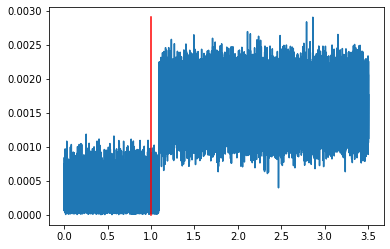

In [72]:
%matplotlib inline
I_r=I.reshape((n_repetition,n_runs))
Q_r=Q.reshape((n_repetition,n_runs))

time_r=time.reshape((n_repetition,n_runs))

idx=8

maxi=max(np.sqrt(I_r[idx,:]**2+Q_r[idx,:]**2))
plt.plot(time_r[idx,:]*1e-9-time_r[idx,0]*1e-9,np.sqrt(I_r[idx,:]**2+Q_r[idx,:]**2))
plt.plot([Pump_Delay*4*1e-9,Pump_Delay*4*1e-9],[0, maxi],"r")

In [130]:
n_empty*50_000*1e-9

1.0

## Multiple frequencies with dual demodulation 

Need to make sure that the new updated IF frequency doesn't go over 350 MHz.
Need to make sure that the readout_len * n_runs is much larger than the pump delay
Note : the maximum number of variables that can be steamed is 100e6. if there is a timestamp attached to it, it will be doubled

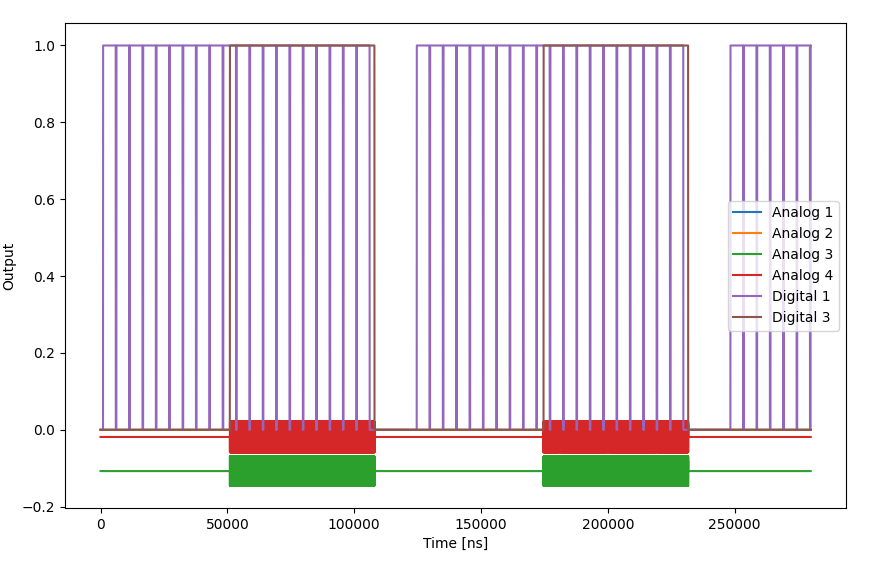

In [22]:
#Variables setting for the program 

Readout_Len=5_000#length of the readout pulse in ns 
config,qm=update_readout_lenght(Readout_Len,config,qmm)

n_runs = 20 #Number of readout to do 

span=1.5 * u.MHz # Span of the pumping 
df = 0.1* u.MHz # Step of the pumping 0.01
IF_center=0.262e9 
freqs = np.arange(IF_center-span/2, IF_center+span/2, df) #sets of pump frequencies 
Offset_IF=0  #-5670.0 +400 #+1000 #+10000
LO_diff=LO_fluxline/2-LO_readout # need to perform this substraction outside of the qua program to avoid having numbers larger than the int allowed 

Pump_Delay=50000//4 # Delay before starting the pump 
cooldown_time_pump = 16000 // 4 # Time delay between applying sucessive pumps upgrading the frequency 

amp_factor=0.3 #Prefactor of the amplitude of the pump 


#Saving the data 
cooldown_date="2023_02_24" #top folder 
device="123" #second folder 
name="Run01" # third folder 
meastype="100ms_1ms_0p4" #Final file name 
datadict={}

#Program time and memory prediction
NumberPoints=n_runs*freqs.shape[0]
print("The Numbber of points is : {}".format(NumberPoints))
print("The fraction from maximum buffer capability is : {}".format(NumberPoints*2/100e6))
print("The estimated time per trace is {} minutes".format((n_runs*(Readout_Len*1e-9))/60))
print("The total estimated time {} minutes".format((NumberPoints*(Readout_Len*1e-9))/60))

The Numbber of points is : 300
The fraction from maximum buffer capability is : 6e-06
The estimated time per trace is 1.6666666666666667e-06 minutes
The total estimated time 2.5e-05 minutes


In [24]:
%%time
%matplotlib qt


with program() as IQ_blobs:
    
    n = declare(int)
    i = declare(int)
    I = declare(fixed)
    Q = declare(fixed)
    assign_variables_to_element("resonator", I,Q) #This line forces the OPX to assign I and Q to the resonator element such that the loops can happen in parallel as intented
    I_st = declare_stream() # Data paths
    Q_st = declare_stream() # Data paths
    
    
    f = declare(int)
    f_readout = declare(int)
   

    with for_(*from_array(f,freqs)):  # loop over the frequency array 
        
        assign(f_readout,LO_diff+f/2+Offset_IF) #update the readout frequency to be 1/2 of the pump frequency 
        update_frequency("resonator",f_readout) # Change the IF frequency of the resonator to demodulate more precisely 
        update_frequency("fluxline",f) # updates the IF frequency to the array 
        
    
         #Delay time before turning the pump on 
        wait(Pump_Delay,"fluxline")
        with for_(i, 0, i < np.round((n_runs*(Readout_Len+300)-Pump_Delay*4)/twoPhoton_len)+1, i + 1): # the 300 is added because there is a time delay associated to saving the data in the steam. The *4 is necessary because the waiting time is in clockcycle 
            play("pumping" * amp(amp_factor), 'fluxline')  # Play the pulse on the fluxline
            
        
        with for_(n, 0, n < n_runs, n + 1):

            #Demodulate for the length 
            measure(
                "fake_readout",
                "resonator",
                None,
                dual_demod.full("cos", "out1", "sin", "out2", I),
                dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
            )

            save(I, I_st) # Save data to path
            save(Q, Q_st) # Save data to path 

            
        #waiting time before the next pump     
        wait(cooldown_time_pump)
        

    with stream_processing():
        I_st.with_timestamps().save_all("I") 
        Q_st.with_timestamps().save_all("Q")
        

        
simulation = True  

if simulation: 
    simulation_config = SimulationConfig(
        duration=70000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
    )
    
    job = qmm.simulate(config, IQ_blobs, simulation_config)
    job.get_simulated_samples().con1.plot(analog_ports={'1','2','3','4' },digital_ports={'1','3'})

    
    
else:
  
    job = qm.execute(IQ_blobs)
    results = fetching_tool(job, data_list=["I", "Q"], mode="live")
    
    # Live plotting
    fig = plt.figure()
    interrupt_on_close(fig, job)  #  Interrupts the job when closing the figure
    
    while results.is_processing():
        I, Q = results.fetch_all()
        
        dt=(I["timestamp"][1]-I["timestamp"][0])*1e-9 #time between sucessive points
        
        I = u.demod2volts(I["value"], pulse_len) #diviser par la duree du pulse 
        Q = u.demod2volts(Q["value"], pulse_len)

        #plotting 
        plt.title("IQ blobs")
        plt.subplot(211)
        plt.cla()
        plt.plot(I[:min(len(I), len(Q))], Q[:min(len(I), len(Q))], ".", markersize=2)
        plt.xlabel("I")
        plt.ylabel("Q")
        plt.axis("equal")
        plt.subplot(212)
        plt.cla()
        tau=np.linspace(1,min(len(I), len(Q)),min(len(I), len(Q)))
        plt.plot(np.unwrap(np.angle(I[:min(len(I), len(Q))]+1j*Q[:min(len(I), len(Q))])), ".", markersize=2)
        plt.xlabel("Nb points")
        plt.ylabel("phase")
        plt.pause(0.1)
       
        
        
        
#Saving 
datadict["LO_fluxline"]=LO_fluxline
datadict["IF_fluxline"]=IF_fluxline
datadict["IF_readout"]=IF_readout
datadict["LO_readout"]=LO_readout
datadict["freqs"]=freqs

datadict["n_runs"]=n_runs
datadict["amp_factor"]=amp_factor
datadict["Offset_IF"]=Offset_IF
datadict["Readout_Len"]=Readout_Len
datadict["Pump_Delay"]=Pump_Delay
datadict["cooldown_time_pump"]=cooldown_time_pump
datadict["config"]=config 
datadict["I"]=I.reshape((freqs.shape[0],n_runs))
datadict["Q"]=Q.reshape((freqs.shape[0],n_runs))
datadict["dt"]=dt

#an.save_data(datadict, meastype, name, device, cooldown_date, bias=0, filepath=r"C:\Users\hqclabo\Documents\Data\gbeaulieu\Two_Photon\\")

2023-04-03 09:32:06,924 - qm - INFO - Flags: 
2023-04-03 09:32:06,924 - qm - INFO - Simulating program
Wall time: 20.1 s


In [ ]:
#Plotting of the different data sets taken 
I_r=I.reshape((freqs.shape[0],n_runs))
Q_r=Q.reshape((freqs.shape[0],n_runs))

plt.close("all") # close all open figures 
for i in range(freqs.shape[0]): # for all frequency, we create the two plot 
    fig = plt.figure()
    plt.subplot(211)
    plt.plot(I_r[i,:], Q_r[i,:], ".", markersize=2)
    plt.xlabel("I (V)")
    plt.ylabel("Q (V)")
    plt.axis("equal")
    plt.title("Pump Frequency : " +str((LO_fluxline+freqs[i])/1e9)+" GHz")
    plt.subplot(212)
    time=np.linspace(1,len(I_r[i,:]), len(I_r[i,:]),len(I_r[i,:]))*dt # time in seconds 
    plt.plot(time,(np.angle(I_r[i,:]+1j*Q_r[i,:]), ".", markersize=2)
    plt.xlabel("Time (us)")
    plt.ylabel("Phase")
    